In [1]:
# =========================================================
# [Cell 1] 환경 설정, 설치 및 라이브러리 임포트
# =========================================================
!pip install -q roboflow torch torchvision opencv-python numpy tqdm segment-anything pycocotools torchmetrics

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

from roboflow import Roboflow
from segment_anything import sam_model_registry
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# 하이퍼파라미터
IMG_SIZE = 1024
BATCH_SIZE = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔥 Device: {DEVICE}, Resolution: {IMG_SIZE}x{IMG_SIZE}")

# SAM 가중치 다운로드
if not os.path.exists("sam_vit_b_01ec64.pth"):
    print("⬇️ Downloading SAM weights...")
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

🔥 Device: cuda, Resolution: 1024x1024


In [2]:
# cell 2
rf = Roboflow(api_key="HG9M6YJZpcCUgAQaKO9v")
project = rf.workspace("arakon").project("detection-base-hqaeg")
version = project.version(6)
dataset = version.download("yolov8")

# 2. Dataset 클래스
def yolo_collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch], 0)
    targets = [b[1] for b in batch]
    return imgs, targets

class YoloDataset(Dataset):
    def __init__(self, root, img_size=1024):
        self.img_dir = os.path.join(root, "images")
        self.label_dir = os.path.join(root, "labels")
        self.files = sorted([x for x in os.listdir(self.img_dir) if x.endswith(('.jpg', '.png', '.jpeg'))])
        self.img_size = img_size

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        img_path = os.path.join(self.img_dir, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize & Normalize
        img = cv2.resize(img, (self.img_size, self.img_size))
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

        label_path = os.path.join(self.label_dir, name.rsplit('.', 1)[0] + ".txt")
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    vals = list(map(float, line.strip().split()))
                    if len(vals) == 5:
                        boxes.append(vals) # cls, cx, cy, w, h
        
        target = torch.tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0, 5))
        return img_tensor, target

# DataLoader 생성
train_loader = DataLoader(YoloDataset(dataset.location + "/train", IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True, collate_fn=yolo_collate_fn, num_workers=2)
val_loader = DataLoader(YoloDataset(dataset.location + "/valid", IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False, collate_fn=yolo_collate_fn, num_workers=2)

loading Roboflow workspace...
loading Roboflow project...


In [3]:
# cell 3
class ConvNormAct(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, k, s, p, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU()
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class SAMDetector(nn.Module):
    def __init__(self, checkpoint_path="sam_vit_b_01ec64.pth", num_classes=3):
        super().__init__()
        print("🔄 Loading SAM Backbone...")
        self.sam = sam_model_registry["vit_b"](checkpoint=checkpoint_path)
        
        # Backbone Freeze
        for param in self.sam.image_encoder.parameters():
            param.requires_grad = False
            
        self.sam_out_dim = 256
        
        # Adapter (FPN)
        self.p4_conv = ConvNormAct(256, 256)
        self.p3_up = nn.Upsample(scale_factor=2, mode='nearest')
        self.p3_conv = ConvNormAct(256, 256)
        self.p5_down = ConvNormAct(256, 256, k=3, s=2, p=1)
        
        # Detection Head
        self.heads = nn.ModuleList([
            nn.Conv2d(256, num_classes + 5, 1) for _ in range(3)
        ])
        
    def forward(self, x):
        with torch.no_grad():
            features = self.sam.image_encoder(x)
            
        p4 = self.p4_conv(features)          
        p3 = self.p3_conv(self.p3_up(p4))    
        p5 = self.p5_down(p4)                
        
        outputs = []
        for i, feat in enumerate([p3, p4, p5]):
            out = self.heads[i](feat)
            cls_p = out[:, :3, ...]
            obj_p = out[:, 3:4, ...]
            box_p = out[:, 4:, ...]
            outputs.append((cls_p, obj_p, box_p))
        return outputs

In [4]:
# =========================================================
# [Cell 4] Loss Function & Utils (IndexError Fixed)
# =========================================================

def box_iou(box1, box2):
    lt = torch.max(box1[:, :2], box2[:, :2])
    rb = torch.min(box1[:, 2:], box2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, 0] * wh[:, 1]
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = area1 + area2 - inter + 1e-6
    return inter / union

class ComputeLoss(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, preds, batch_targets, img_size):
        loss_total = 0.0
        strides = [8, 16, 32]
        
        for i, (cls_p, obj_p, box_p) in enumerate(preds):
            stride = strides[i]
            B, _, H, W = cls_p.shape
            device = cls_p.device
            
            grid_y, grid_x = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
            grid = torch.stack((grid_x, grid_y), 2).float()
            
            b_sig = box_p.permute(0, 2, 3, 1).sigmoid() 
            pred_cx = (b_sig[..., 0] * 2.0 - 0.5 + grid[..., 0]) * stride
            pred_cy = (b_sig[..., 1] * 2.0 - 0.5 + grid[..., 1]) * stride
            pred_w = (b_sig[..., 2] * 2.0) ** 2 * stride
            pred_h = (b_sig[..., 3] * 2.0) ** 2 * stride
            
            pred_xyxy = torch.stack([pred_cx - pred_w/2, pred_cy - pred_h/2, 
                                     pred_cx + pred_w/2, pred_cy + pred_h/2], dim=-1)
            
            anchors_flat = (grid + 0.5) * stride 
            anchors_flat = anchors_flat.view(-1, 2)
            
            obj_target = torch.zeros(B, H, W, 1, device=device)
            cls_target = torch.zeros(B, H, W, self.num_classes, device=device)
            loss_box_layer = 0.0
            num_pos_layer = 0
            
            for b in range(B):
                gt = batch_targets[b]
                if len(gt) == 0: continue
                gt_cls = gt[:, 0].long().to(device)
                cx, cy, w, h = gt[:, 1]*img_size, gt[:, 2]*img_size, gt[:, 3]*img_size, gt[:, 4]*img_size
                gt_xyxy = torch.stack([cx-w/2, cy-h/2, cx+w/2, cy+h/2], dim=1).to(device)
                
                lt = gt_xyxy[:, None, :2]
                rb = gt_xyxy[:, None, 2:]
                deltas = torch.cat((anchors_flat[None] - lt, rb - anchors_flat[None]), dim=2)
                is_in_gt = deltas.min(dim=2)[0] > 0 
                matched_gt_idx = is_in_gt.max(dim=0)[1] 
                has_match = is_in_gt.max(dim=0)[0] 
                
                if has_match.sum() > 0:
                    pos_mask = has_match.view(H, W)
                    obj_target[b, pos_mask] = 1.0
                    cls_target[b, pos_mask, gt_cls[matched_gt_idx[has_match]]] = 1.0
                    iou = box_iou(pred_xyxy[b, pos_mask], gt_xyxy[matched_gt_idx[has_match]])
                    loss_box_layer += (1.0 - iou).sum()
                    num_pos_layer += has_match.sum()

            loss_obj = F.binary_cross_entropy_with_logits(obj_p.permute(0,2,3,1).reshape(-1,1), obj_target.reshape(-1,1), reduction='sum')
            loss_cls = F.binary_cross_entropy_with_logits(cls_p.permute(0,2,3,1).reshape(-1,self.num_classes), cls_target.reshape(-1,self.num_classes), reduction='sum')
            loss_total += (loss_obj + loss_cls + loss_box_layer * 5.0) / max(1.0, num_pos_layer) / B

        return loss_total

def post_process(outputs, conf_thres=0.5, iou_thres=0.45):
    all_boxes, all_scores, all_classes = [], [], []
    strides = [8, 16, 32]
    
    for i, (cls_p, obj_p, box_p) in enumerate(outputs):
        device = cls_p.device
        B, _, H, W = cls_p.shape
        stride = strides[i]
        
        grid_y, grid_x = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
        grid = torch.stack((grid_x, grid_y), 2).float()
        grid = grid.unsqueeze(0).expand(B, -1, -1, -1)
        
        obj_sig = obj_p.permute(0, 2, 3, 1).sigmoid().squeeze(-1)
        cls_sig = cls_p.permute(0, 2, 3, 1).sigmoid()
        box_sig = box_p.permute(0, 2, 3, 1).sigmoid()
        
        class_conf, class_pred = torch.max(cls_sig, dim=-1)
        conf = obj_sig * class_conf
        mask = conf > conf_thres
        
        if mask.any():
            grid_m = grid[mask]; box_m = box_sig[mask]; conf_m = conf[mask]; cls_m = class_pred[mask]
            
            pred_cx = (box_m[:, 0] * 2.0 - 0.5 + grid_m[:, 0]) * stride
            pred_cy = (box_m[:, 1] * 2.0 - 0.5 + grid_m[:, 1]) * stride
            pred_w = (box_m[:, 2] * 2.0) ** 2 * stride
            pred_h = (box_m[:, 3] * 2.0) ** 2 * stride
            
            boxes = torch.stack([pred_cx - pred_w/2, pred_cy - pred_h/2, 
                                 pred_cx + pred_w/2, pred_cy + pred_h/2], dim=1)
            all_boxes.append(boxes)
            all_scores.append(conf_m)
            all_classes.append(cls_m)
            
    if not all_boxes: return []
    
    pred_boxes = torch.cat(all_boxes, dim=0)
    pred_scores = torch.cat(all_scores, dim=0)
    pred_classes = torch.cat(all_classes, dim=0)
    
    keep = torchvision.ops.nms(pred_boxes, pred_scores, iou_thres)
    return [[*pred_boxes[k].tolist(), pred_scores[k].item(), pred_classes[k].item()] for k in keep]

def plot_results(img_tensor, detections):
    img = img_tensor.cpu().permute(1, 2, 0).numpy() * 255.0
    img = img.astype(np.uint8).copy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    for x1, y1, x2, y2, score, cls_id in detections:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img, f"{int(cls_id)}: {score:.2f}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [8]:
# =========================================================
# [Cell 5] Training & Validation (Fixed for mAP)
# =========================================================

# 1. 모델 및 학습 설정
model = SAMDetector(num_classes=3).to(DEVICE)
criterion = ComputeLoss(num_classes=3).to(DEVICE)
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)
scaler = torch.amp.GradScaler('cuda')

# 2. mAP Metric 초기화
metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox').to(DEVICE)
metric.warn_on_many_detections = False

# [수정됨] 후처리 함수: 상위 N개만 남기는 max_det 추가
def post_process_safe(outputs, conf_thres=0.01, iou_thres=0.45, max_det=300):
    all_boxes, all_scores, all_classes = [], [], []
    strides = [8, 16, 32]
    
    for i, (cls_p, obj_p, box_p) in enumerate(outputs):
        device = cls_p.device
        B, _, H, W = cls_p.shape
        stride = strides[i]
        
        # Grid 생성 및 확장
        grid_y, grid_x = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
        grid = torch.stack((grid_x, grid_y), 2).float().unsqueeze(0).expand(B, -1, -1, -1)
        
        obj_sig = obj_p.permute(0, 2, 3, 1).sigmoid().squeeze(-1)
        cls_sig = cls_p.permute(0, 2, 3, 1).sigmoid()
        box_sig = box_p.permute(0, 2, 3, 1).sigmoid()
        
        class_conf, class_pred = torch.max(cls_sig, dim=-1)
        conf = obj_sig * class_conf
        mask = conf > conf_thres
        
        if mask.any():
            grid_m = grid[mask]; box_m = box_sig[mask]; conf_m = conf[mask]; cls_m = class_pred[mask]
            
            pred_cx = (box_m[:, 0] * 2.0 - 0.5 + grid_m[:, 0]) * stride
            pred_cy = (box_m[:, 1] * 2.0 - 0.5 + grid_m[:, 1]) * stride
            pred_w = (box_m[:, 2] * 2.0) ** 2 * stride
            pred_h = (box_m[:, 3] * 2.0) ** 2 * stride
            
            boxes = torch.stack([pred_cx - pred_w/2, pred_cy - pred_h/2, 
                                 pred_cx + pred_w/2, pred_cy + pred_h/2], dim=1)
            all_boxes.append(boxes)
            all_scores.append(conf_m)
            all_classes.append(cls_m)
            
    if not all_boxes: return []
    
    pred_boxes = torch.cat(all_boxes, dim=0)
    pred_scores = torch.cat(all_scores, dim=0)
    pred_classes = torch.cat(all_classes, dim=0)
    
    # NMS 실행
    keep = torchvision.ops.nms(pred_boxes, pred_scores, iou_thres)
    
    # [핵심] 점수 높은 순으로 최대 max_det 개수만 남김 (속도/메모리 보호)
    keep = keep[:max_det]
    
    return [[*pred_boxes[k].tolist(), pred_scores[k].item(), pred_classes[k].item()] for k in keep]


EPOCHS = 10
best_map = 0.0 
save_path = "sam_best.pth"

print(f"🚀 Start Training (Threshold: 0.01, MaxDets: 300)...")

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS} [Train]")
    train_loss = 0.0
    
    for imgs, targets in loop:
        imgs = imgs.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            preds = model(imgs)
            loss = criterion(preds, targets, IMG_SIZE)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        loop.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Validation ---
    model.eval()
    metric.reset()
    
    val_loop = tqdm(val_loader, desc=f"Ep {epoch+1}/{EPOCHS} [Valid]")
    max_score_detected = 0.0 # 디버깅용: 모델이 내뱉은 최고 점수 확인
    
    with torch.no_grad():
        for imgs, targets in val_loop:
            imgs = imgs.to(DEVICE)
            with torch.amp.autocast('cuda'):
                preds = model(imgs)
            
            batch_preds_list = []
            B = imgs.shape[0]
            for b_idx in range(B):
                single_sample_preds = [(p[0][b_idx:b_idx+1], p[1][b_idx:b_idx+1], p[2][b_idx:b_idx+1]) for p in preds]
                
                # [설정 변경] conf_thres=0.01로 낮추고, max_det=300으로 제한
                dets = post_process_safe(single_sample_preds, conf_thres=0.01, max_det=300)
                
                if len(dets) > 0:
                    d_tensor = torch.tensor(dets, device=DEVICE)
                    current_max = d_tensor[:, 4].max().item()
                    if current_max > max_score_detected: max_score_detected = current_max
                    
                    batch_preds_list.append({'boxes': d_tensor[:, :4], 'scores': d_tensor[:, 4], 'labels': d_tensor[:, 5].long()})
                else:
                    batch_preds_list.append({'boxes': torch.empty((0, 4), device=DEVICE), 'scores': torch.tensor([], device=DEVICE), 'labels': torch.tensor([], dtype=torch.long, device=DEVICE)})

            batch_target_list = []
            for t in targets:
                if len(t) > 0:
                    t = t.to(DEVICE)
                    cls = t[:, 0].long()
                    cx, cy, w, h = t[:, 1]*IMG_SIZE, t[:, 2]*IMG_SIZE, t[:, 3]*IMG_SIZE, t[:, 4]*IMG_SIZE
                    batch_target_list.append({'boxes': torch.stack([cx-w/2, cy-h/2, cx+w/2, cy+h/2], dim=1), 'labels': cls})
                else:
                    batch_target_list.append({'boxes': torch.empty((0, 4), device=DEVICE), 'labels': torch.tensor([], dtype=torch.long, device=DEVICE)})
            
            metric.update(batch_preds_list, batch_target_list)

    val_metrics = metric.compute()
    map_50 = val_metrics['map_50'].item()
    
    # 로그 출력에 Max Score 추가 (모델이 얼마나 확신하는지 확인)
    print(f"📉 Train Loss: {avg_train_loss:.4f} | 🎯 mAP50: {map_50:.4f} | 🔍 Max Score: {max_score_detected:.4f}")
    
    if map_50 > best_map:
        best_map = map_50
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best Model Saved (mAP50: {best_map:.4f})")
    
    print("-" * 30)

print("🏁 Training Finished.")

🔄 Loading SAM Backbone...
🚀 Start Training (Threshold: 0.01, MaxDets: 300)...


Ep 1/10 [Valid]: 100%|██████████| 33/33 [00:14<00:00,  2.29it/s]


📉 Train Loss: 8.8252 | 🎯 mAP50: 0.0001 | 🔍 Max Score: 0.9966
💾 Best Model Saved (mAP50: 0.0001)
------------------------------


Ep 2/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.55it/s]


📉 Train Loss: 6.7010 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9785
------------------------------


Ep 3/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.61it/s]


📉 Train Loss: 6.2931 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9629
------------------------------


Ep 4/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.64it/s]


📉 Train Loss: 6.0803 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9414
------------------------------


Ep 5/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.58it/s]


📉 Train Loss: 6.0525 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9639
------------------------------


Ep 6/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.60it/s]


📉 Train Loss: 5.8835 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9697
------------------------------


Ep 7/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.61it/s]


📉 Train Loss: 5.8949 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9824
------------------------------


Ep 8/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s]


📉 Train Loss: 5.8412 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9800
------------------------------


Ep 9/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s]


📉 Train Loss: 5.8331 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9868
------------------------------


Ep 10/10 [Valid]: 100%|██████████| 33/33 [00:12<00:00,  2.66it/s]


📉 Train Loss: 5.7981 | 🎯 mAP50: 0.0000 | 🔍 Max Score: 0.9897
------------------------------
🏁 Training Finished.



🚀 Starting Evaluation on Test Set with Best Model...

[Test Batch 0] Visualization:


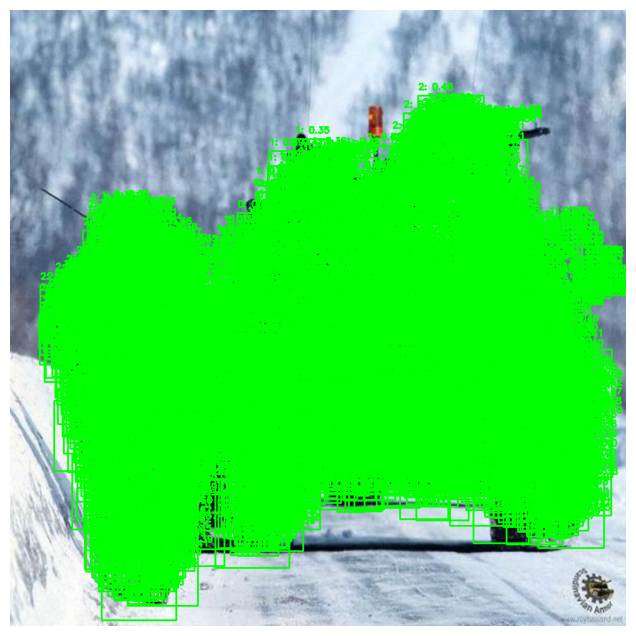


[Test Batch 1] Visualization:


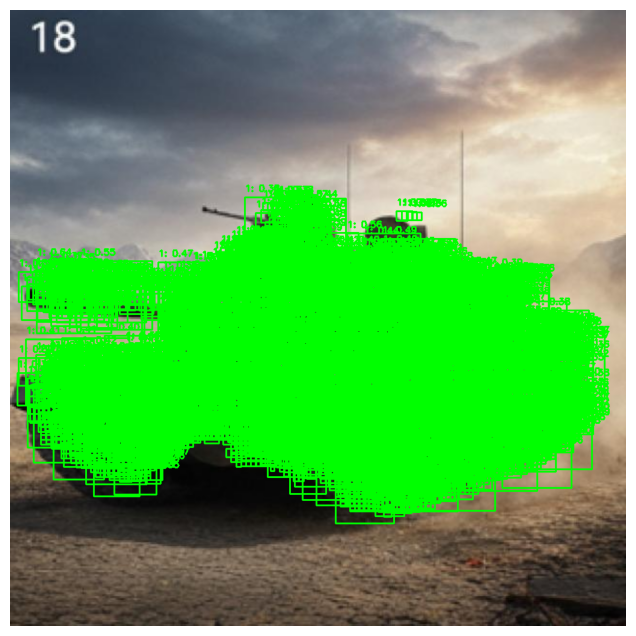


[Test Batch 2] Visualization:


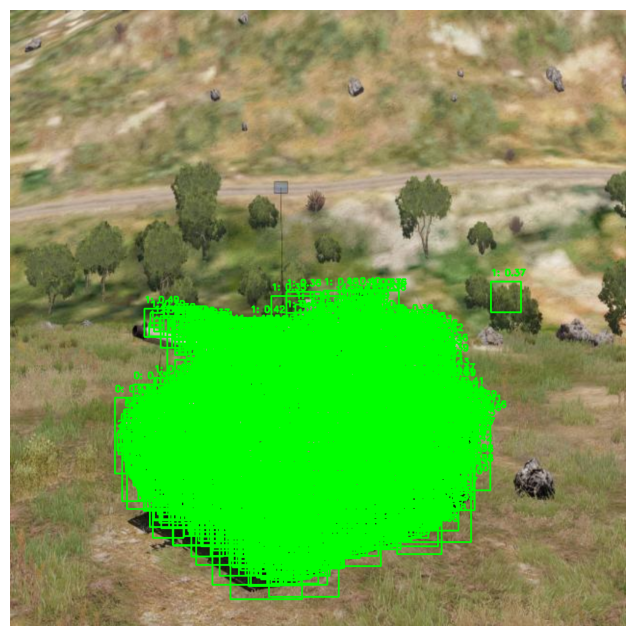

In [ ]:
# =========================================================
# [Cell 6] Test Dataset Evaluation
# =========================================================

# Test Loader 생성
if 'test_loader' not in locals():
    test_loader = DataLoader(YoloDataset(dataset.location + "/test", IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False, collate_fn=yolo_collate_fn, num_workers=2)

print("\n🚀 Starting Evaluation on Test Set with Best Model...")

# 저장된 Best 모델 로드
model.load_state_dict(torch.load("sam_best.pth"))
model.eval()
metric.reset()

with torch.no_grad():
    for i, (imgs, targets) in enumerate(test_loader):
        imgs = imgs.to(DEVICE)
        with torch.amp.autocast('cuda'):
            preds = model(imgs)
        
        # mAP 데이터 축적
        B = imgs.shape[0]
        batch_preds_list = []
        for b_idx in range(B):
            single_sample_preds = [(p[0][b_idx:b_idx+1], p[1][b_idx:b_idx+1], p[2][b_idx:b_idx+1]) for p in preds]
            dets = post_process(single_sample_preds, conf_thres=0.01)
            
            if len(dets) > 0:
                d_tensor = torch.tensor(dets, device=DEVICE)
                batch_preds_list.append({'boxes': d_tensor[:, :4], 'scores': d_tensor[:, 4], 'labels': d_tensor[:, 5].long()})
            else:
                batch_preds_list.append({'boxes': torch.empty((0, 4), device=DEVICE), 'scores': torch.tensor([], device=DEVICE), 'labels': torch.tensor([], dtype=torch.long, device=DEVICE)})
        
        batch_target_list = []
        for t in targets:
            if len(t) > 0:
                t = t.to(DEVICE)
                cls = t[:, 0].long()
                cx, cy, w, h = t[:, 1]*IMG_SIZE, t[:, 2]*IMG_SIZE, t[:, 3]*IMG_SIZE, t[:, 4]*IMG_SIZE
                batch_target_list.append({'boxes': torch.stack([cx-w/2, cy-h/2, cx+w/2, cy+h/2], dim=1), 'labels': cls})
            else:
                batch_target_list.append({'boxes': torch.empty((0, 4), device=DEVICE), 'labels': torch.tensor([], dtype=torch.long, device=DEVICE)})
        
        metric.update(batch_preds_list, batch_target_list)
        
        # 시각화: 처음 3개 배치만 확인
        if i < 3:
            print(f"\n[Test Batch {i}] Visualization:")
            vis_preds = [(p[0][0:1], p[1][0:1], p[2][0:1]) for p in preds]
            vis_dets = post_process(vis_preds, conf_thres=0.35) 
            plot_results(imgs[0], vis_dets)

test_metrics = metric.compute()
print(f"\n🏆 Final Test mAP50: {test_metrics['map_50'].item():.4f}")
print(f"🏆 Final Test mAP50-95: {test_metrics['map'].item():.4f}")